In [25]:
import pandas as pd
import numpy as np
import src
import warnings
import os
warnings.filterwarnings("ignore", category=FutureWarning)

from pybedtools.bedtool import BedTool
from pybedtools import cleanup

import matplotlib.pyplot as plt
import seaborn as sns

figure_path = src.figures_path / "segmentation"
os.makedirs(figure_path, exist_ok=True)

cleanup()

In [77]:
path = src.external_data_path / "segmentation" / "hg19_M0_VB.bed"
segmentation = pd.read_csv(path, sep="\t", header=None, names = src.coords + ['state'])
states = segmentation.state.str.split('_', expand=True)
states.columns = ['code', 'name', 'n']
segmentation = pd.concat((segmentation, states), axis=1)
segmentation.head()

,chr,start,end,state,code,name,n
0,chr1,10000,10200,E4_proximal_1,E4,proximal,1
1,chr1,10200,11600,E11_weak_1,E11,weak,1
2,chr1,11600,11800,E4_proximal_2,E4,proximal,2
3,chr1,11800,21000,E11_weak_2,E11,weak,2
4,chr1,21000,22400,E23_proximal_1,E23,proximal,1


In [78]:
window = 25000
consensus_boundaries = pd.read_csv(src.interim_data_path / "consensus_boundaries" / "consensus_boundaries_w{}.tsv".format(window), sep = "\t")
consensus_boundaries['consensus_boundary_uid'] = np.arange(consensus_boundaries.shape[0], dtype=int)
consensus_boundaries.head()

,chr,start,end,boundary_uid,cell_type,n_cell_types,n_boundaries,Ery,MK,Mac0,Mon,nB,nCD4,nCD8,length,covered_genome,consensus_boundary_uid
0,chr1,1612500,1612500,Mon_0000_start,Mon,1,1,0,0,0,1,0,0,0,1,3.223947e-10,0
1,chr1,1646875,1646875,nB_0000_start,nB,1,1,0,0,0,0,1,0,0,1,3.223947e-10,1
2,chr1,1842500,1847500,"nB_0000_end,Ery_0000_start,Mon_0000_end","Ery,nB,Mon",3,3,1,0,0,1,1,0,0,5001,1.612296e-06,2
3,chr1,2112500,2112500,"nB_0001_start,Mac0_0000_start","nB,Mac0",2,2,0,0,1,0,1,0,0,1,3.223947e-10,3
4,chr1,2342500,2350000,"nB_0001_end,Mac0_0000_end,Ery_0000_end,nB_0002...","nCD8,Ery,nB,Mac0",4,5,1,0,1,0,2,0,1,7501,2.418282e-06,4


In [79]:
bounds_with_segs = BedTool.from_dataframe(consensus_boundaries.sort_values(src.coords))\
                            .intersect(BedTool.from_dataframe(segmentation.sort_values(src.coords)), wa=True, wb=True)\
                            .to_dataframe(names=consensus_boundaries.columns.tolist() + 
                                          segmentation.columns.map(lambda x: 'seg_' + x if x in consensus_boundaries.columns else x).tolist())
bounds_with_segs.head()

,chr,start,end,boundary_uid,cell_type,n_cell_types,n_boundaries,Ery,MK,Mac0,...,length,covered_genome,consensus_boundary_uid,seg_chr,seg_start,seg_end,state,code,name,n
0,chr1,1612500,1612500,Mon_0000_start,Mon,1,1,0,0,0,...,1,3.223947e-10,0,chr1,1606439,1616639,E11_weak_94,E11,weak,94
1,chr1,1646875,1646875,nB_0000_start,nB,1,1,0,0,0,...,1,3.223947e-10,1,chr1,1635039,1653439,E11_weak_97,E11,weak,97
2,chr1,1842500,1847500,"nB_0000_end,Ery_0000_start,Mon_0000_end","Ery,nB,Mon",3,3,1,0,0,...,5001,1.612296e-06,2,chr1,1842039,1845239,E11_weak_114,E11,weak,114
3,chr1,1842500,1847500,"nB_0000_end,Ery_0000_start,Mon_0000_end","Ery,nB,Mon",3,3,1,0,0,...,5001,1.612296e-06,2,chr1,1845239,1849639,E20_dead_88,E20,dead,88
4,chr1,2112500,2112500,"nB_0001_start,Mac0_0000_start","nB,Mac0",2,2,0,0,1,...,1,3.223947e-10,3,chr1,2112439,2120439,E11_weak_130,E11,weak,130


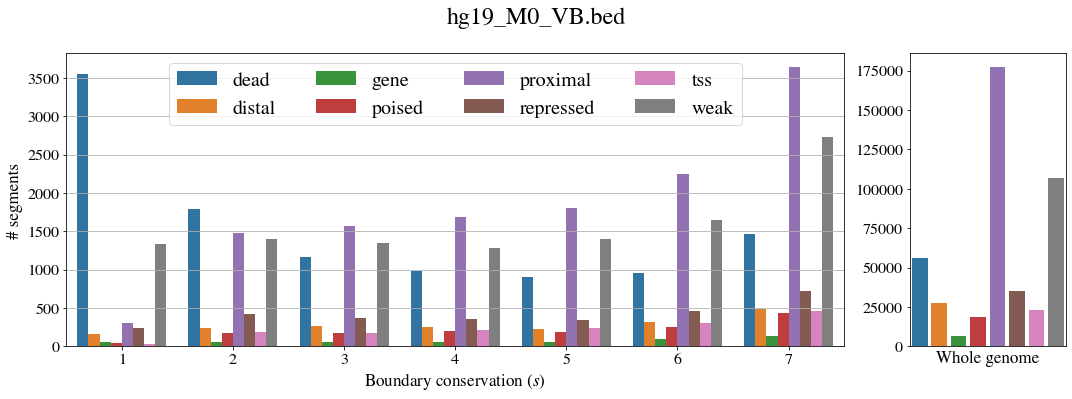

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), gridspec_kw=dict(width_ratios=[5,1]))
sns.countplot(data=bounds_with_segs, x='n_cell_types', hue="name", hue_order=sorted(segmentation.name.unique()), ax=axes[0])
axes[0].legend(ncol=4, fontsize=20)
axes[0].grid(axis='y')
axes[0].set_xlabel("Boundary conservation ($s$)")
axes[0].set_ylabel("# segments")

sns.countplot(data=segmentation, x='name', order=sorted(segmentation.name.unique()), ax=axes[1])
axes[1].set_xticks([])
axes[1].set_xlabel("Whole genome")
axes[1].set_ylabel("")
fig.suptitle(str(path).split("/")[-1], x=0.5, y=1.1, fontsize=24)
plt.show()